In [1]:
# Importing necessary libraries
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer
from transformers import SegformerFeatureExtractor
from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

bin C:\Users\skoka3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bitsandbytes\libbitsandbytes_cuda113.dll


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
# Define the dataset class
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_names, feature_extractor, augmentation=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = img_names
        self.feature_extractor = feature_extractor
        self.augmentation = augmentation
        self.img_names = [name for name in img_names if name.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx].replace('.jpg', '.png'))
        

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        # Resize images and masks to a common size, e.g., (512, 512)
        resize_transform = A.Resize(512, 512)
        augmented = resize_transform(image=np.array(image), mask=np.array(mask))
        image, mask = augmented['image'], augmented['mask']
        
        # Apply additional augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        # Process image and mask
        encoded_inputs = self.feature_extractor(images=image, return_tensors="pt")
        encoded_inputs['labels'] = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Add channel dimension
        
        # Remove the batch dimension added by the feature extractor
        for k, v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze(0)
        
        return encoded_inputs

In [4]:
# Define augmentations
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Add more transformations as needed
    ]
    return A.Compose(train_transform)

In [5]:
# Load the model and feature extractor
checkpoint = "nvidia/mit-b0"
feature_extractor = SegformerFeatureExtractor.from_pretrained(checkpoint)
model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint)

C:\Users\skoka3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\skoka3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.ba

In [6]:
# Assuming you have directories with images and masks for training
image_dir = r"C:\Users\skoka3\Desktop\Sravan\CIVE-FP\data\imageDamage\imageDamage"
mask_dir = r"C:\Users\skoka3\Desktop\Sravan\CIVE-FP\data\imageDamage\FineDamageReducedPNG"



In [7]:
img_names = os.listdir(image_dir)
train_img_names, valid_img_names = train_test_split(img_names, test_size=0.2, random_state=42)


In [8]:
# Create the datasets
train_dataset = CustomImageDataset(
    img_dir=image_dir,
    mask_dir=mask_dir,
    img_names=train_img_names,
    feature_extractor=feature_extractor,
    augmentation=get_training_augmentation()
)

valid_dataset = CustomImageDataset(
    img_dir=image_dir,
    mask_dir=mask_dir,
    img_names=valid_img_names,
    feature_extractor=feature_extractor
)


In [9]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    # tokenizer argument removed
)

# Train the model
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/2240 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.14501823484897614, 'eval_runtime': 452.8259, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.124, 'epoch': 1.0}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.06789228320121765, 'eval_runtime': 451.9354, 'eval_samples_per_second': 0.496, 'eval_steps_per_second': 0.124, 'epoch': 2.0}
{'loss': 1.3057, 'learning_rate': 0.00015535714285714287, 'epoch': 2.23}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.058518052101135254, 'eval_runtime': 452.1434, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.124, 'epoch': 3.0}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.055926788598299026, 'eval_runtime': 452.4514, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.124, 'epoch': 4.0}
{'loss': 0.0571, 'learning_rate': 0.00011071428571428572, 'epoch': 4.46}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.053929347544908524, 'eval_runtime': 452.0582, 'eval_samples_per_second': 0.496, 'eval_steps_per_second': 0.124, 'epoch': 5.0}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.052203092724084854, 'eval_runtime': 452.1797, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.124, 'epoch': 6.0}
{'loss': 0.0499, 'learning_rate': 6.607142857142857e-05, 'epoch': 6.7}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.04996376857161522, 'eval_runtime': 451.9579, 'eval_samples_per_second': 0.496, 'eval_steps_per_second': 0.124, 'epoch': 7.0}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.04946743696928024, 'eval_runtime': 452.1876, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.124, 'epoch': 8.0}
{'loss': 0.0465, 'learning_rate': 2.1428571428571428e-05, 'epoch': 8.93}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.04840749502182007, 'eval_runtime': 452.0419, 'eval_samples_per_second': 0.496, 'eval_steps_per_second': 0.124, 'epoch': 9.0}


  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 0.048327624797821045, 'eval_runtime': 452.2262, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.124, 'epoch': 10.0}
{'train_runtime': 26700.2003, 'train_samples_per_second': 0.335, 'train_steps_per_second': 0.084, 'train_loss': 0.3305436325924737, 'epoch': 10.0}


TrainOutput(global_step=2240, training_loss=0.3305436325924737, metrics={'train_runtime': 26700.2003, 'train_samples_per_second': 0.335, 'train_steps_per_second': 0.084, 'train_loss': 0.3305436325924737, 'epoch': 10.0})

In [10]:
model.save_pretrained("best_segformer.pth")


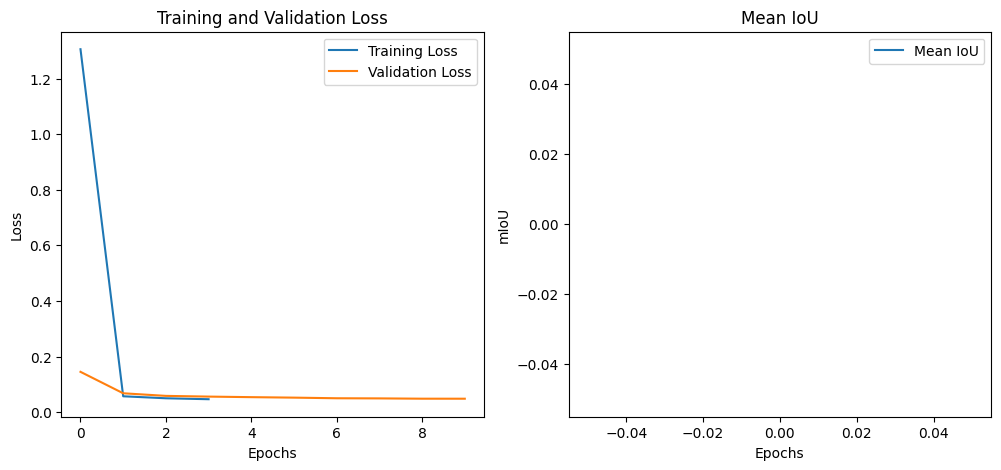

In [13]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

training_loss = [log['loss'] for log in training_logs if 'loss' in log]
validation_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
miou = [log['eval_miou'] for log in training_logs if 'eval_miou' in log]  # Replace 'eval_miou' with your actual IoU metric name

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting mean IoU
plt.subplot(1, 2, 2)
plt.plot(miou, label='Mean IoU')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()

plt.show()
